# Hot word detection task

In [ ]:
from pathlib import Path

import torchaudio

In [ ]:
#|default_exp hits.data

In [ ]:
#|export
from IPython.display import Audio
from torch import tensor
from types import SimpleNamespace
import requests, torch
import librosa, matplotlib.pyplot as plt, numpy as np, fastcore.all as fc
from fastcore.all import noop, L
from torch.utils.data import Subset, DataLoader
import torchaudio.transforms as T

See main task [here](https://github.com/MenshikovDmitry/TSU_AI_Course/blob/main/module_3.%20Sound%20Processing%20ang%20hot-word%20detection/README.md)

## Loading data from stream

In [ ]:
#|export
def load_stream(file = '../data/stream.mp3'):
    stream_url = 'https://radio.kotah.ru/soundcheck'
    r = requests.get(stream_url, stream=True)
    with open(file, 'wb') as f:
        try:
            for block in r.iter_content(4096):
                f.write(block)
        except KeyboardInterrupt:
            pass

In [ ]:
# load and convert it to wav
if not Path('../data/stream.wav').exists():
    load_stream()
    !ffmpeg -i ../data/stream.mp3 ../data/stream.wav

In [ ]:
path_stones = Path('../data/stones')
files = path_stones.ls()
path = Path('../data/stream.wav')
sr = 16_000
window_size_s = 1.0 # seconds
window_size = int(window_size_s*sr)
stride = int(0.7*sr)

In [ ]:
s, sr = librosa.load(path, sr=sr)

## Split audio into frames

In [ ]:
#|export
def split_audio(arr, w_size, stride):
    n_frames = (arr.shape[0] - w_size)//stride + 1
    strides = (stride*arr.dtype.itemsize, arr.dtype.itemsize)
    return np.lib.stride_tricks.as_strided(arr, shape=(n_frames, w_size), strides=strides).copy()

In [ ]:
#|export
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    return ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

def describe(audio, label=None, sr=16_000, figsize=(12, 4), spec_tfm = T.Spectrogram()):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].plot(audio, label=label)
    if label is not None: axes[0].legend()
    tfms = fc.Pipeline([tensor, T.Resample(new_freq=sr), spec_tfm])
    im = plot_spectrogram(tfms(audio), ax=axes[1])
    fig.colorbar(im, ax=axes, format="%+2.0f dB")
    return Audio(audio, rate=sr)

In [ ]:
frames = split_audio(s, window_size, stride=stride)

In [ ]:
i = iter(range(0, len(s)))

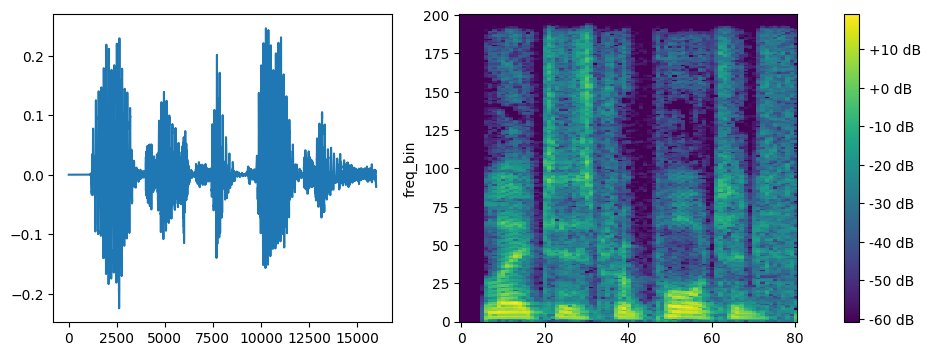

In [ ]:
idx = next(i)
describe(frames[idx])

Audio that says 'STONES'

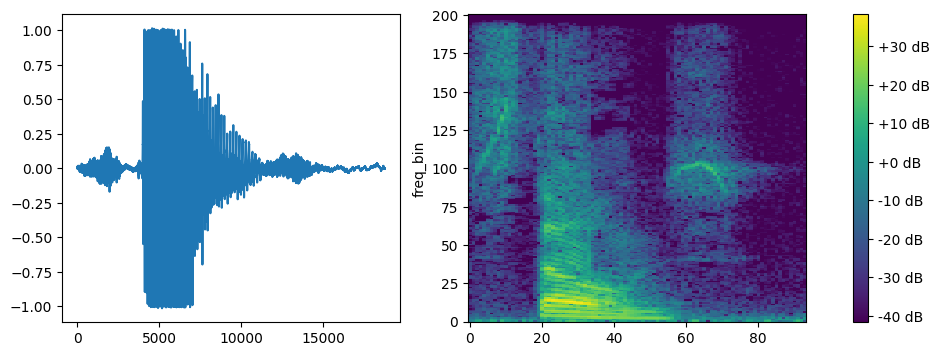

In [ ]:
stones = L(librosa.load(f, sr=sr)[0] for f in files)
# decrease volume
stones = stones.map(lambda x: x)
idx = 11
describe(stones[idx])

## Create dataset

In [ ]:
frames.shape[0]

8618

In [ ]:
# |export
def rand_slice(a, size):
    """Randomly slice an array."""
    if len(a) >= size:
        start = np.random.randint(0, 1+len(a)-size)
        return a[start:start+size]
    pad = size - len(a)
    left = np.random.randint(0, pad)
    return np.pad(a, (left, pad - left))


def merge_with_stones(frames, stones, n, window_size):
    # randomly select n stones and frames
    stone_samples = stones[np.random.choice(len(stones), n)]
    
    # select random frames without replacement
    fr_samples = frames[np.random.choice(frames.shape[0], n, replace=False)]
    
    p = 0.1+np.random.rand(n, 1).astype(frames.dtype)*.3
    return [(1-p)*rand_slice(s, window_size) + p*f for p, s, f in zip(p, stone_samples, fr_samples)]


def generate_dataset(frames, stones, n_samples=2000, window_size=19_200):
    xs = merge_with_stones(frames, stones, n_samples, window_size)
    xs = np.concatenate((np.stack(xs), frames[np.random.choice(
        frames.shape[0], n_samples, replace=False)]))

    ys = np.concatenate((np.ones(n_samples), np.zeros(n_samples)))
    return xs, ys

In [ ]:
n = int(frames.shape[0]*.7)
frames_train, frames_valid = frames[:n], frames[n:]
# make half of the dataset merged with stones
train_xs, train_ys = generate_dataset(frames_train, stones, n//2, window_size)
# take the rest for testing
valid_xs, valid_ys = generate_dataset(frames_valid, stones, frames.shape[0]-n, window_size)

Save to files

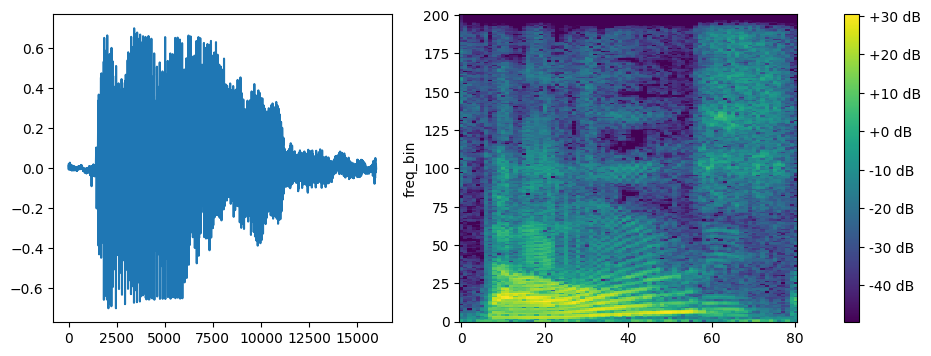

In [ ]:
describe(train_xs[2])

In [ ]:
np.save('../data/train/dataset_x', train_xs)
np.save('../data/train/dataset_y', train_ys)
np.save('../data/valid/dataset_x', valid_xs)
np.save('../data/valid/dataset_y', valid_ys)

### Create basic dataset class

In [ ]:
#|export
def merge_items(xs, ys):
    return [(x,y) for x,y in zip(xs,ys)]

class TfmDataset:
    def __init__(self, items, x_tfms=None, y_tfms=None) -> None:
        self.items = items
        self.x_tfms = fc.Pipeline(x_tfms)
        self.y_tfms = fc.Pipeline(y_tfms)
    
    def __len__(self): return len(self.items)
    
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return [self[i] for i in range(*idx.indices(len(self)))]
        x, y = self.items[idx]
        return self.x_tfms(x), self.y_tfms(y)

In [ ]:
#|export
def random_split_dataset(ds, split_frac=0.8):
    '''shuffle and split dataset'''
    split_size = int(len(ds) * split_frac)
    indices = torch.randperm(len(ds))
    train_indices = indices[:split_size]
    val_indices = indices[split_size:]
    train_subset = Subset(ds, train_indices)
    val_subset = Subset(ds, val_indices)
    
    return train_subset, val_subset

@fc.delegates(DataLoader.__init__)
def dataloaders(train_ds, test_ds, **kwargs):
    return SimpleNamespace(train=DataLoader(train_ds,**kwargs), valid=DataLoader(test_ds,**kwargs))